In [1]:
import numpy as np

import jax.numpy as jnp

from jax import config
config.update("jax_enable_x64", True)


from matplotlib import pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
klin, plin = np.loadtxt('Pk_Planck15_Table4.txt', unpack=True);

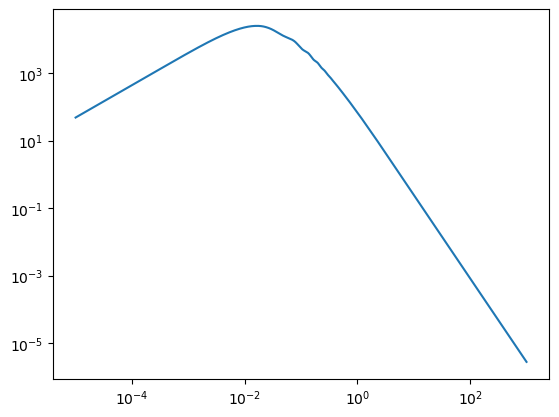

In [3]:
from Utils.loginterp_jax import loginterp_jax

kint = np.logspace(-5,3,2000)
pint = loginterp_jax(klin,plin)(kint)

plt.loglog(kint, pint)

In [4]:
from Utils.spherical_bessel_transform import SphericalBesselTransform as SBT

In [5]:
sph = SBT(kint,fourier=True)

In [6]:
rr, xi0 = sph.sph(0,pint)

(0.0, 200.0)

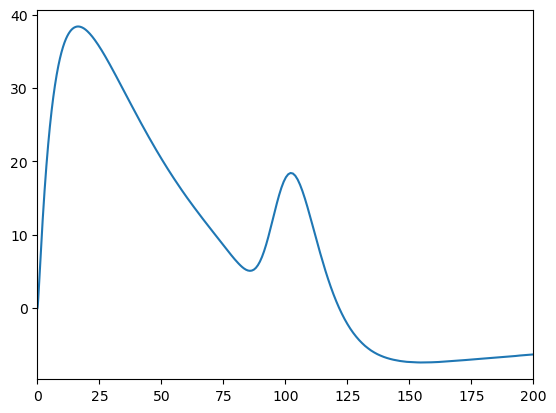

In [7]:
plt.plot(rr, rr**2 * xi0)

plt.xlim(0,200)

In [8]:
from Utils.spherical_bessel_transform_ncol import SphericalBesselTransform as SBTn

In [9]:
sphn = SBTn(kint,ncol=1,fourier=True)

In [10]:
ptest = pint #np.array([pint, pint])

In [11]:
rr, xi0 = sphn.sph(0,ptest)

(0.0, 150.0)

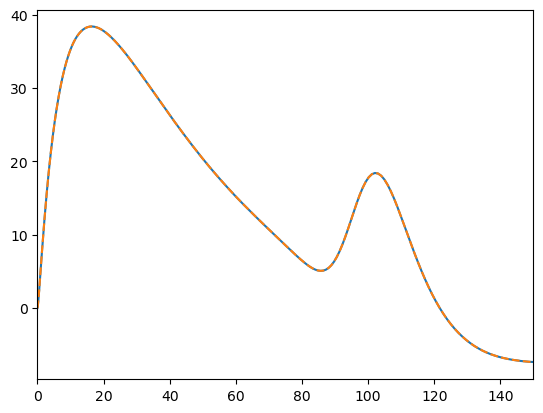

In [12]:
plt.plot(rr, rr**2 * xi0[0,:])
plt.plot(rr, rr**2 * xi0[1,:], '--')

plt.xlim(0,150)

In [13]:
xi0.shape

(1, 2000)

In [14]:
from Utils.qfuncfft_jax import QFuncFFT_JAX

In [15]:
qfunc = QFuncFFT_JAX(kint, pint * np.exp(-(kint/10)**2))

(0.001, 1)

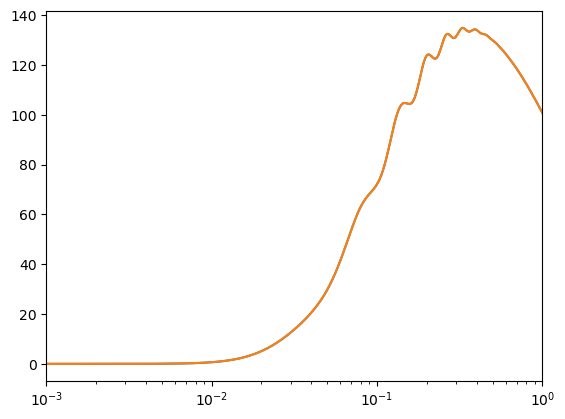

In [16]:
plt.semilogx(qfunc.k, qfunc.k*qfunc.Rb3)
plt.semilogx(qfunc.k, 4/7*qfunc.k*qfunc.R1)

plt.xlim(1e-3,1)

In [17]:
from transfer_functions import Zenbu

In [18]:
modPT = Zenbu(klin,plin)

In [19]:
D = np.sqrt(0.1)

modPT.p_integrals(1.0, D)

DeviceArray([11.70042747,  1.04788576,  0.822448  ,  8.10358229], dtype=float64)

In [20]:
from jax import jit

pjit = jit(modPT.p_integrals)

pjit(1.0, D)

DeviceArray([11.70042747,  1.04788576,  0.822448  ,  8.10358229], dtype=float64)

In [21]:
import time

t1 = time.time()
modPT.p_integrals(1.0, D)
t2 = time.time()
print(t2-t1)

t1 = time.time()
pjit(1.0, D)
t2 = time.time()

print(t2-t1)

0.04207301139831543
0.0008740425109863281


In [25]:
kmin = 1e-3
kmax = 3
nk = 50
kv = jnp.logspace( jnp.log10(kmin),  jnp.log10(kmax), nk)

t1 = time.time()

ptable =  jnp.zeros([nk, modPT.num_power_components+1])
ptable = ptable.at[:,0].set(kv)

for ii, kk in enumerate(kv):
    ptable = ptable.at[ii,1:].set(pjit(kk,1))

t2 = time.time()

print(t2-t1)

0.1806640625


In [26]:
@jit
def make_ptable(D):
    ptable =  jnp.zeros([nk, modPT.num_power_components+1])
    ptable = ptable.at[:,0].set(kv)

    for ii, kk in enumerate(kv):
        ptable = ptable.at[ii,1:].set(modPT.p_integrals(kk,D))
    
    return ptable

In [27]:
t1 = time.time()
make_ptable(1)
t2 = time.time()

In [29]:
t1 = time.time()
make_ptable(1)
t2 = time.time()

print(t2-t1)

0.06915807723999023


In [30]:
#ptable_jit = jit(modPT.make_ptable)

In [31]:
t1 = time.time()
#ptable = ptable_jit(D)
t2 = time.time()

print(t2-t1)

9.083747863769531e-05


In [32]:
#modPT.make_ptable()

(10.0, 30000.0)

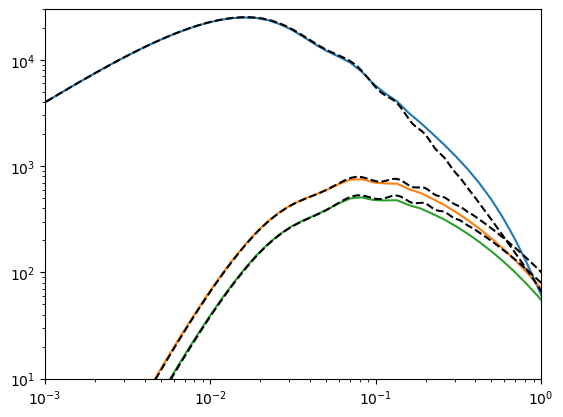

In [33]:
plt.loglog(ptable[:,0], ptable[:,1])
plt.loglog(ptable[:,0], ptable[:,2])
plt.loglog(ptable[:,0], ptable[:,3])

plt.loglog(modPT.qf.k, modPT.qf.p,'k--')
plt.loglog(modPT.qf.k, modPT.qf.Rb3, 'k--')
plt.loglog(modPT.qf.k, 3./7*(modPT.qf.R1 + modPT.qf.R2), 'k--')


plt.xlim(1e-3,1)
plt.ylim(1e1,3e4)